# Regular LSTM with PyTorch

Import libraries

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Import dataset

In [149]:
data = pd.read_csv('AirPassengers.csv')
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


Preprocessing

In [150]:
data['Date'] = pd.to_datetime(data['Month'])
data.drop('Month', axis=1, inplace=True)
data = data.set_index('Date')
data

,#Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


View Dataset

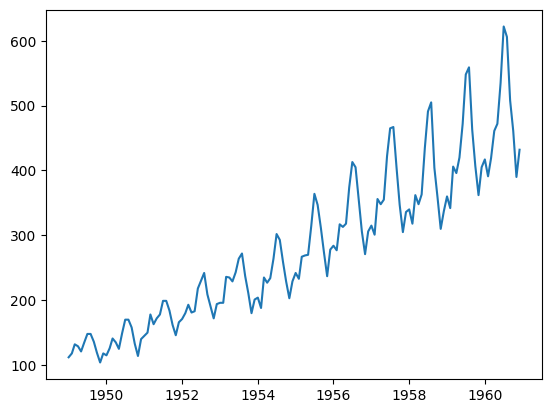

In [151]:
plt.plot(data.index, data['#Passengers'])

In [152]:
data['year_cos'] = data.index.year * np.cos(data.index.month * (2 * np.pi / 12))
data['year_sin'] = data.index.year * np.sin(data.index.month * (2 * np.pi / 12))
data['month_cos'] = data.index.month * np.cos(data.index.year * (2 * np.pi / 12))
data['month_sin'] = data.index.month * np.sin(data.index.year * (2 * np.pi / 12))
data.head(200)

,#Passengers,year_cos,year_sin,month_cos,month_sin
Date,,,,,
1949-01-01,112,1.687884e+03,9.745000e+02,-0.866025,0.500000
1949-02-01,118,9.745000e+02,1.687884e+03,-1.732051,1.000000
1949-03-01,132,1.193418e-13,1.949000e+03,-2.598076,1.500000
1949-04-01,129,-9.745000e+02,1.687884e+03,-3.464102,2.000000
1949-05-01,121,-1.687884e+03,9.745000e+02,-4.330127,2.500000
...,...,...,...,...,...
1960-08-01,606,-9.800000e+02,-1.697410e+03,-4.000000,6.928203
1960-09-01,508,-3.600462e-13,-1.960000e+03,-4.500000,7.794229
1960-10-01,461,9.800000e+02,-1.697410e+03,-5.000000,8.660254


Generate the sequence from the dataset

In [ ]:
import pandas as pd
import numpy as np

# 1. Create the lagged features for the target variable '#Passengers'
sequence_length = 5
for i in range(1, sequence_length + 1):
    data[f'passengers_lag_{i}'] = data['#Passengers'].shift(i)

# 2. Clean the data by dropping rows with NaN values created by the shift
data.dropna(inplace=True)

# 3. Define the features (X) and the target (y)
# The target is the original passenger count for the current row.
target_column = '#Passengers'

# The features are all the new lag columns AND the original exogenous features.
feature_columns = [col for col in data.columns if 'lag' in col]
exogenous_features = ['year_sin', 'year_cos', 'month_sin', 'month_cos']
feature_columns.extend(exogenous_features)

X = data[feature_columns]
y = data[target_column]

# 4. Perform a chronological train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
y_train = y_train.to_frame()
y_test = y_test.to_frame()

# --- Print the results ---
print("--- Final Shapes for XGBoost ---")
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

print("\\n--- Sample of the Final Training Data (X_train) ---")
X_train.head()
y_train.head()

--- Final Shapes for XGBoost ---
X_train shape: (111, 9)
X_test shape: (28, 9)
y_train shape: (111, 1)
y_test shape: (28, 1)
\n--- Sample of the Final Training Data (X_train) ---


,#Passengers
Date,
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136
1949-10-01,119


Normalize the data

In [154]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

Transform numpy array to tensor

In [155]:
print("--- Tensors After Reshaping (Ready for LSTM) ---")
print("X_train final shape:", X_train.shape)
print("y_train final shape:", y_train.shape)
print("X_test final shape:", X_test.shape)
print("y_test final shape:", y_test.shape)

--- Tensors After Reshaping (Ready for LSTM) ---
X_train final shape: (111, 9)
y_train final shape: (111, 1)
X_test final shape: (28, 9)
y_test final shape: (28, 1)


### Create the XGBoost Model

In [170]:
xgb_model = xgb.XGBRegressor(
    n_estimators=10000,
    max_depth=3,
    learning_rate=0.001,
    objective='reg:squarederror'
)

### Train regular LSTM

In [171]:
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=True,)
print("Training complete.")

Training XGBoost model...
[0]	validation_0-rmse:2.22973
[1]	validation_0-rmse:2.22831
[2]	validation_0-rmse:2.22690
[3]	validation_0-rmse:2.22548
[4]	validation_0-rmse:2.22406
[5]	validation_0-rmse:2.22265
[6]	validation_0-rmse:2.22124
[7]	validation_0-rmse:2.21983
[8]	validation_0-rmse:2.21842
[9]	validation_0-rmse:2.21701
[10]	validation_0-rmse:2.21560
[11]	validation_0-rmse:2.21420
[12]	validation_0-rmse:2.21279
[13]	validation_0-rmse:2.21139
[14]	validation_0-rmse:2.20999
[15]	validation_0-rmse:2.20859
[16]	validation_0-rmse:2.20719
[17]	validation_0-rmse:2.20580
[18]	validation_0-rmse:2.20440
[19]	validation_0-rmse:2.20301
[20]	validation_0-rmse:2.20162
[21]	validation_0-rmse:2.20022
[22]	validation_0-rmse:2.19884
[23]	validation_0-rmse:2.19745
[24]	validation_0-rmse:2.19606
[25]	validation_0-rmse:2.19468
[26]	validation_0-rmse:2.19329
[27]	validation_0-rmse:2.19191
[28]	validation_0-rmse:2.19053
[29]	validation_0-rmse:2.18915
[30]	validation_0-rmse:2.18777
[31]	validation_0-rmse:

Plot the results of the LSTM model

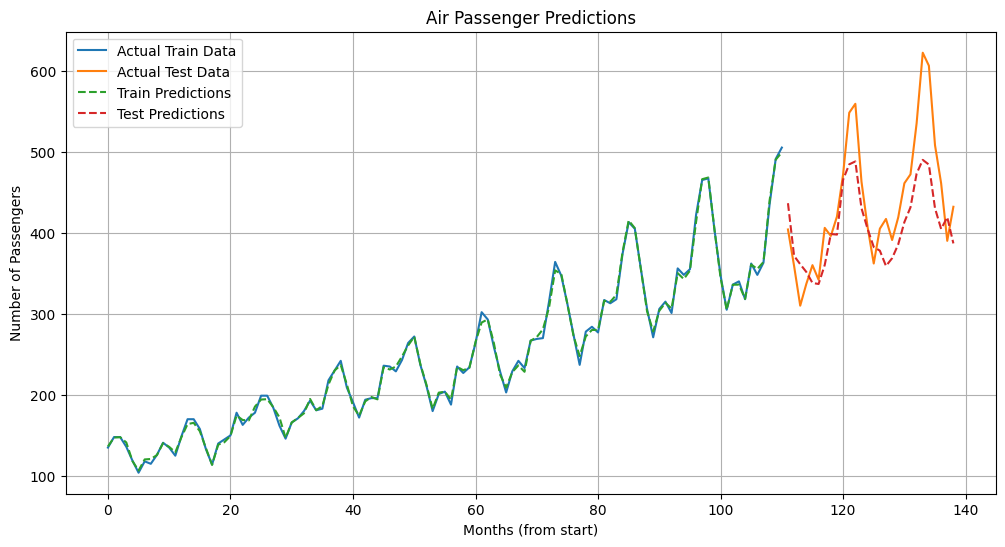

In [172]:
# --- 1. Get Predictions ---
train_plot = xgb_model.predict(X_train)
test_plot = xgb_model.predict(X_test)

# --- 2. Inverse Transform Data for Plotting ---
# Move tensors to CPU and convert to NumPy arrays
train_predictions = scaler_y.inverse_transform(train_plot.reshape(-1, 1))
train_actuals = scaler_y.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler_y.inverse_transform(test_plot.reshape(-1, 1))
test_actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# --- 3. Create the Plot ---
plt.figure(figsize=(12, 6))

# Plot the original passenger data (actuals)
# We plot both train and test actuals together to get a continuous line
plt.plot(scaler_y.inverse_transform(y_train), label='Actual Train Data')
plt.plot(range(len(train_actuals), len(train_actuals) + len(test_actuals)), test_actuals, label='Actual Test Data')

# Plot the training predictions
# This will start from index 0 and go up to the end of the training set
plt.plot(train_predictions, label='Train Predictions', linestyle='--')

# Plot the test predictions
# This needs a new x-axis range that starts after the training data
test_x_axis = range(len(train_predictions), len(train_predictions) + len(test_predictions))
plt.plot(test_x_axis, test_predictions, label='Test Predictions', linestyle='--')


plt.title('Air Passenger Predictions')
plt.xlabel('Months (from start)')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()